# CS503 Lab-4 : Working with Support Vector Machines

---

Total Points: **100**

---
**Overview**

---
This lab contains two major components, organized as below:

**1. Implementing a MultiClass Linear SVM Using Hinge Loss and Gradient Descent for**   (70 Points)

    1.1 Classifying a Linearly Separable 2D Toy Dataset (4 Classes)
    1.2 Classifying the Cifar10 Image Dataset           (10 Classes)

**2. SVM Using Sklearn Package for**  (30 Points)

    1.1 Classifying a Non-Linearly Separable 2D Toy Dataset (2 Classes)


---
**General Instructions:**

---
1. You have to do this lab individually

2. Please start **early** and do not wait till the submission deadline 

3. For students using google colab, please upload the folder to your drive and provide the directory name in the following cell. (A video demo for the same will be provided)

4. On completing the lab, your models and experiment details will be saved as to the 'outputs' folder. You are however required to zip the entire folder including the python notebook, the saved files and the generated plots and upload to classroom. 
    
        Zip the entire lab folder and name it as <ROLL_NO>_<FIRSTNAME> (all small letters)
        Eg: 2018csb1132_shivam.zip
        
        Upload this single zip file to classroom

5. You are required to fill in your code only where you are asked to. Do not modify other parts of the provided code skeleton. 
    Areas where you have to put in code are marked as below. 
        ### BEGIN - Enter your code below  ###        
        
        ### END ###
    
    Eg. of a completed code block:
        ### BEGIN - Enter your code below  ###        
        x = np.random.randint(1,10)
        return x
        ### END ###

6. The details about each function you have to complete is provided alongisde its defintion. Ensure that the function returns the specified output wherever necessary.
        
7. The written code/ functions will be auto tested for correctness. So please do ensure that your code is error free.

8. Your observations for each subpart should contain the takeways and learnings obtained from each experiment. It should also include brief description of the different hyperparameter settings you tried and the observed model behaviour.

9. Details about the divison of points is given in each subsection. 

10. All the necessary and sufficient instructions and comments have been provided in this notebook. Make sure you read all the provided information, including the code comments.

11. Students are expected to follow the **honor code** of the class.

In [20]:
## Please Fill In Your Name, ID and EMAIL below:

student_name = "Aman Dhawan"
student_id   = "2018csb1070"
student_email= "2018csb1070@iitrpr.ac.in"


**Instructions for Running in Google Colab**

---
* To run the lab on colab, upload the extracted folder to your drive. 
* Then right click 'lab4_svm.ipynb' in the uploaded drive folder and chose open with google colab.
* Provide the path to the uploaded directory in the cell below.

(You can use the given code block below without changing the path if you have uploaded the folder to the root directory of your drive)

---

In [21]:
import os
from IPython.display import Image
if 'google.colab' in str(get_ipython()):
  root_dir = "/gdrive/MyDrive"
  lab_dir  = "CS503_Lab4"
  
  working_dir = os.path.join(root_dir,lab_dir)
  from google.colab import drive
  drive.mount('/gdrive',force_remount=True)
  
  if("lab4_svm.ipynb" in os.listdir(working_dir)):
    print("Successfully Loaded Lab Directory")
    os.chdir(working_dir)
  else:
    print("Failed to Load the Directory from "+working_dir+".\nPlease check the given 'lab_dir' is correct and rerun.")
    

Mounted at /gdrive
Successfully Loaded Lab Directory


----
**Part-1 : Implementing SVM Using Gradient Descent** (70 Points)
----
In the first section, we will implement a Linear SVM using gradient descent and the Hinge Loss. Detailed notes about the loss function to be implementd and its gradient computation is given below. Please take time to go through, understand and derive the gradients by yourself before starting the implementation. A pdf containing the same is also provided in the root directory of the lab.


==>Linear SVM Loss Function



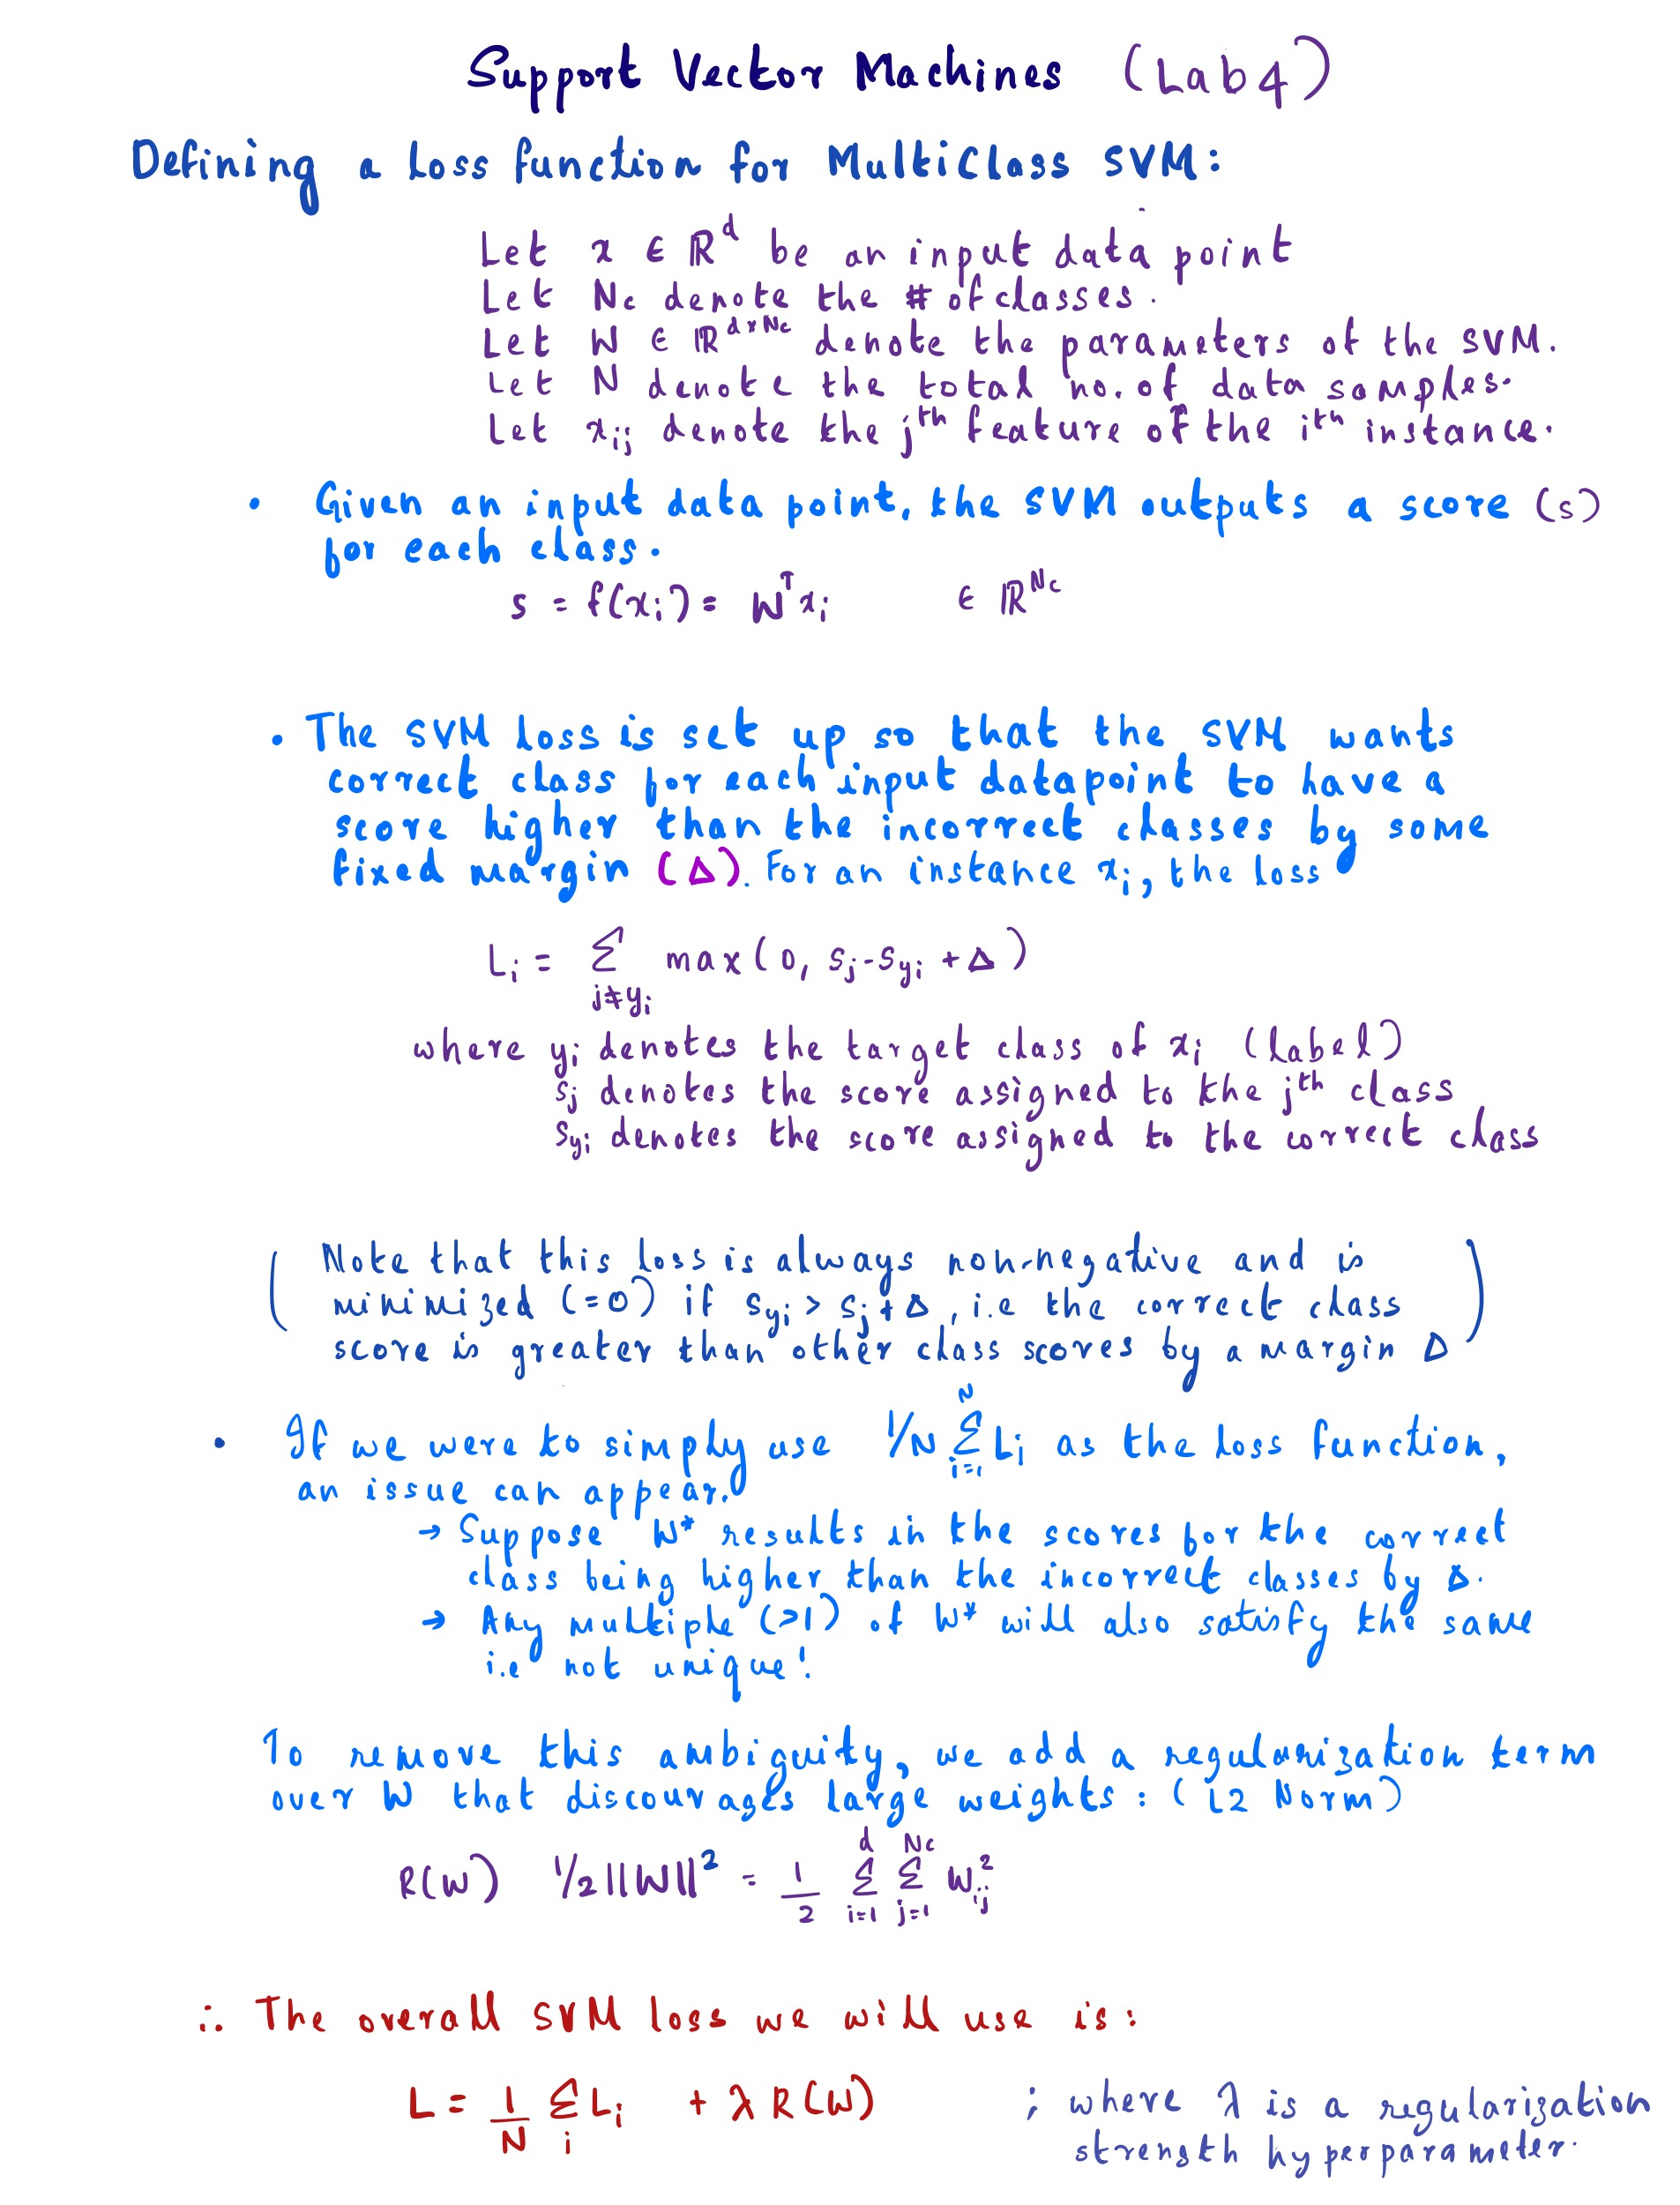

In [22]:
print("\n==>Linear SVM Loss Function\n")
Image("./files/notes/svm1.jpg")


==>Linear SVM Gradient (1)



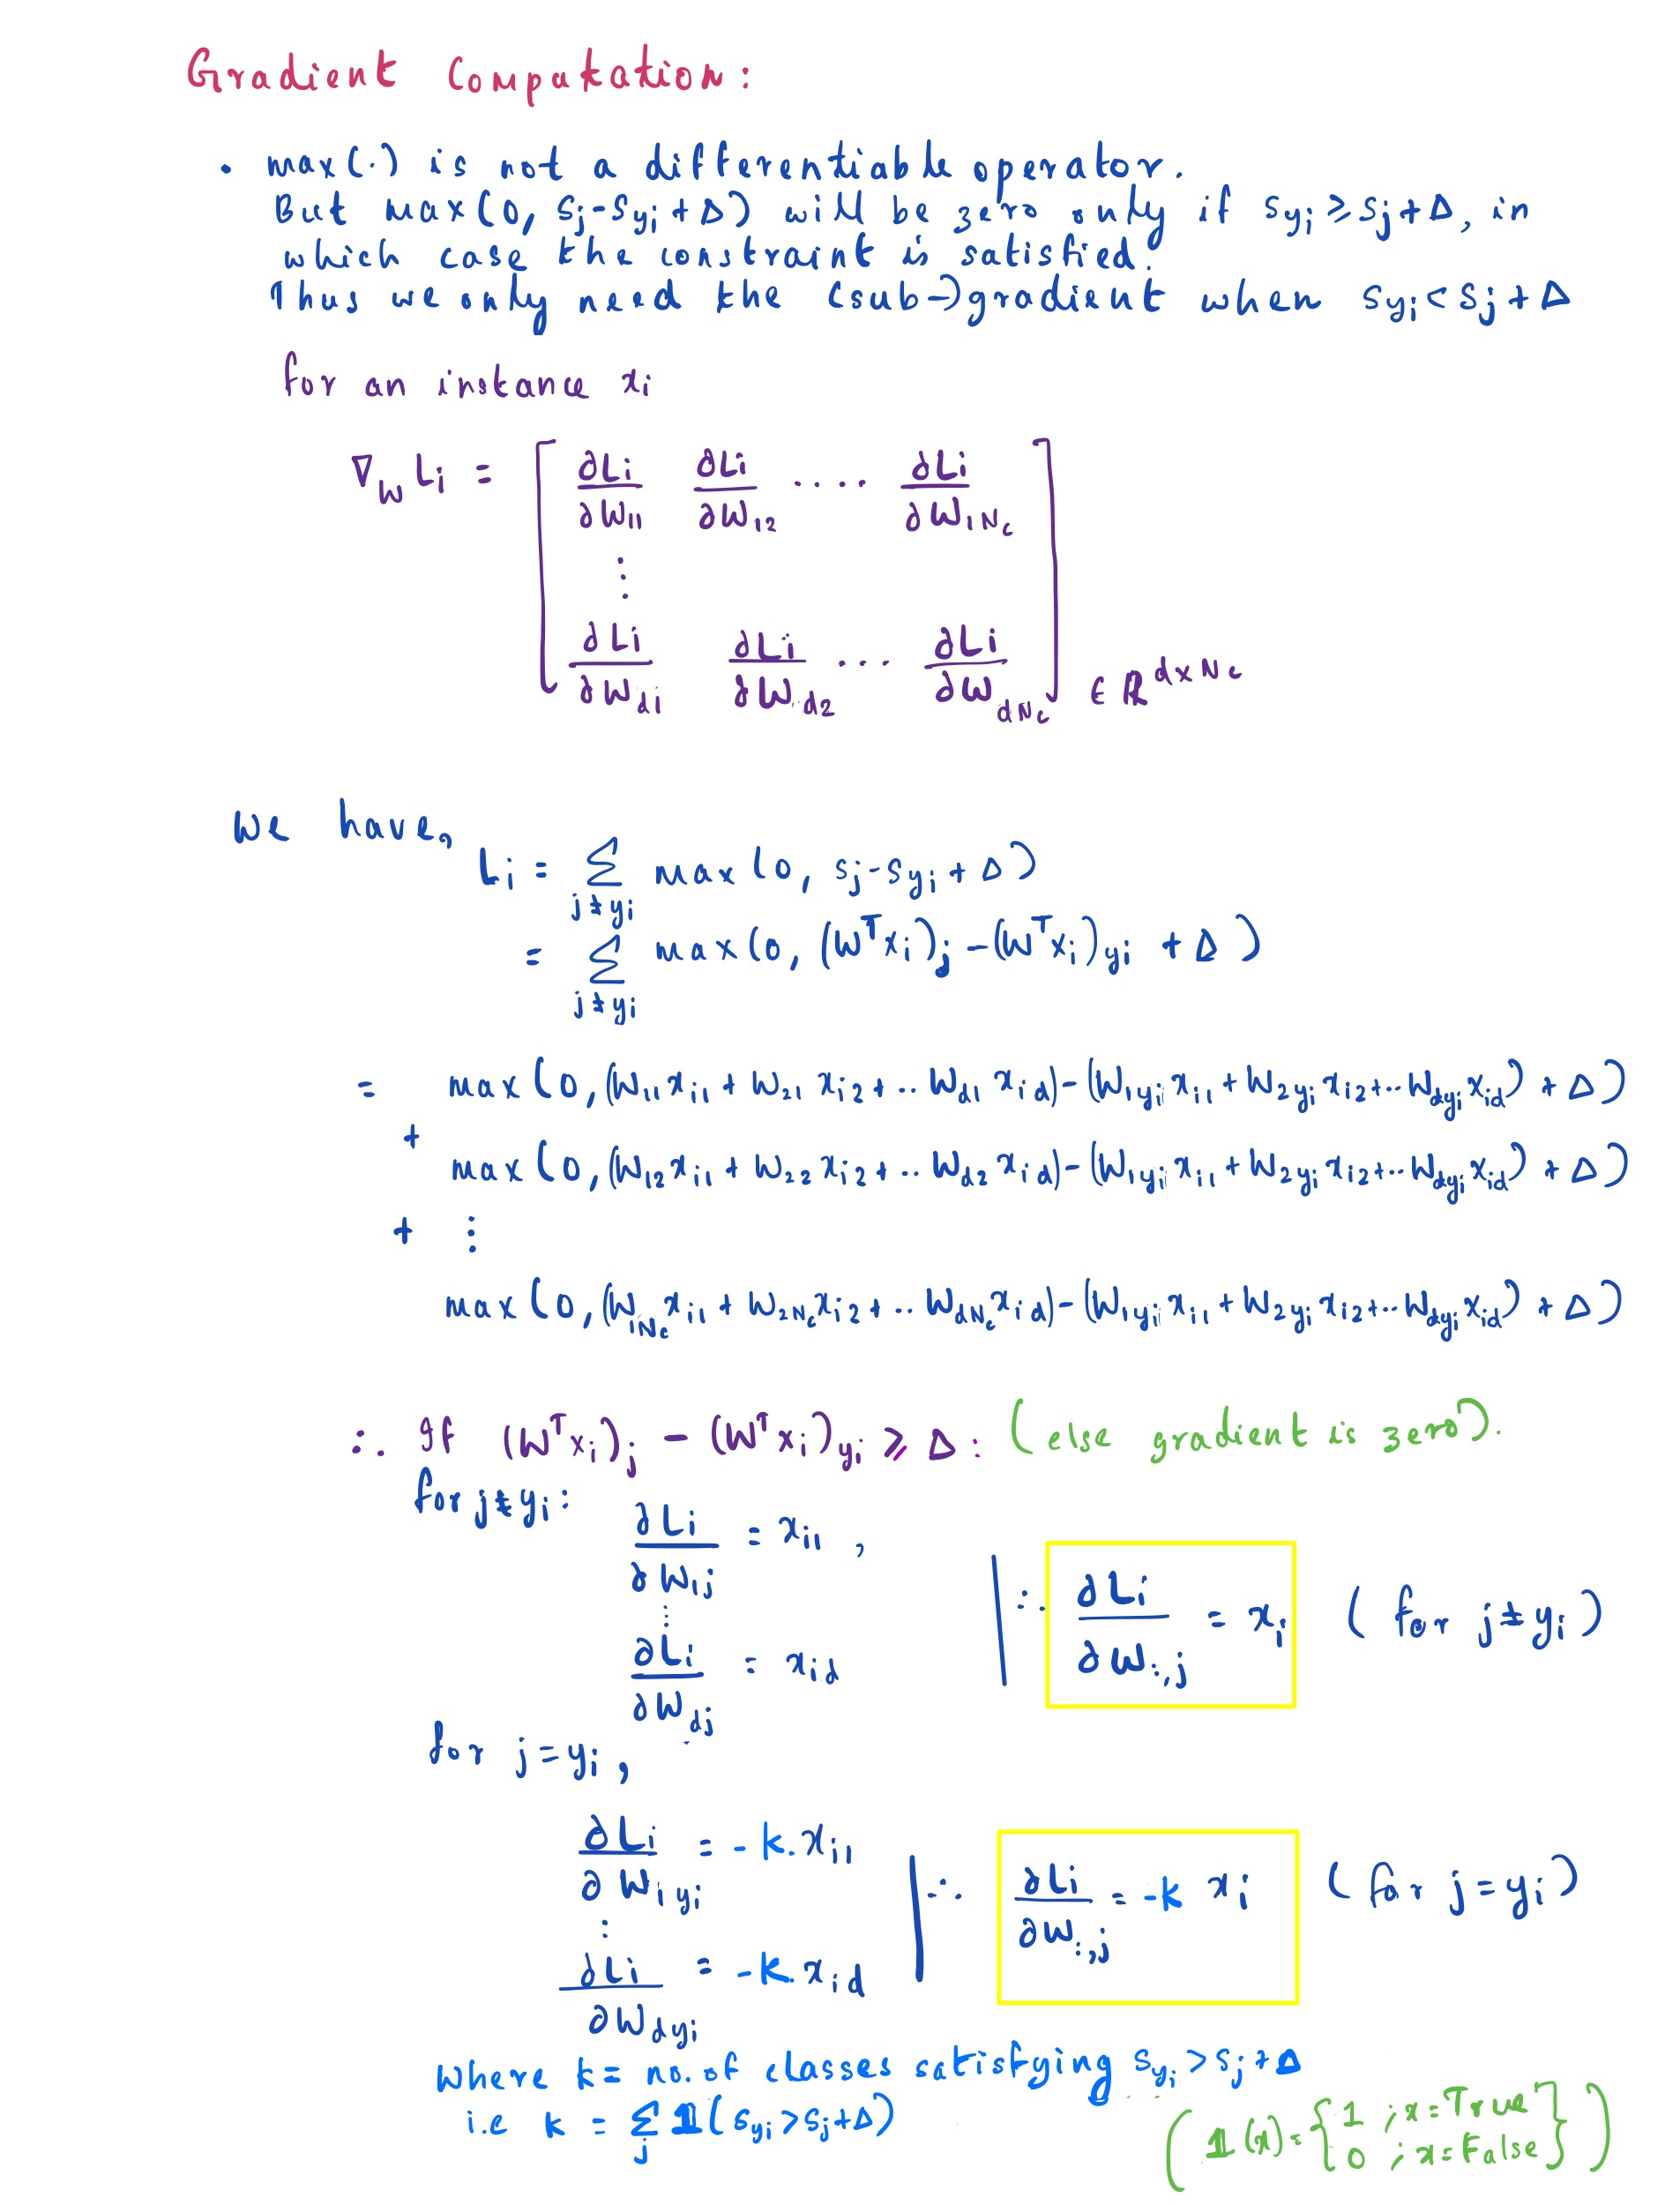

In [23]:
print("\n==>Linear SVM Gradient (1)\n")
Image("./files/notes/svm2.jpg")


==>Linear SVM Gradient (2) 



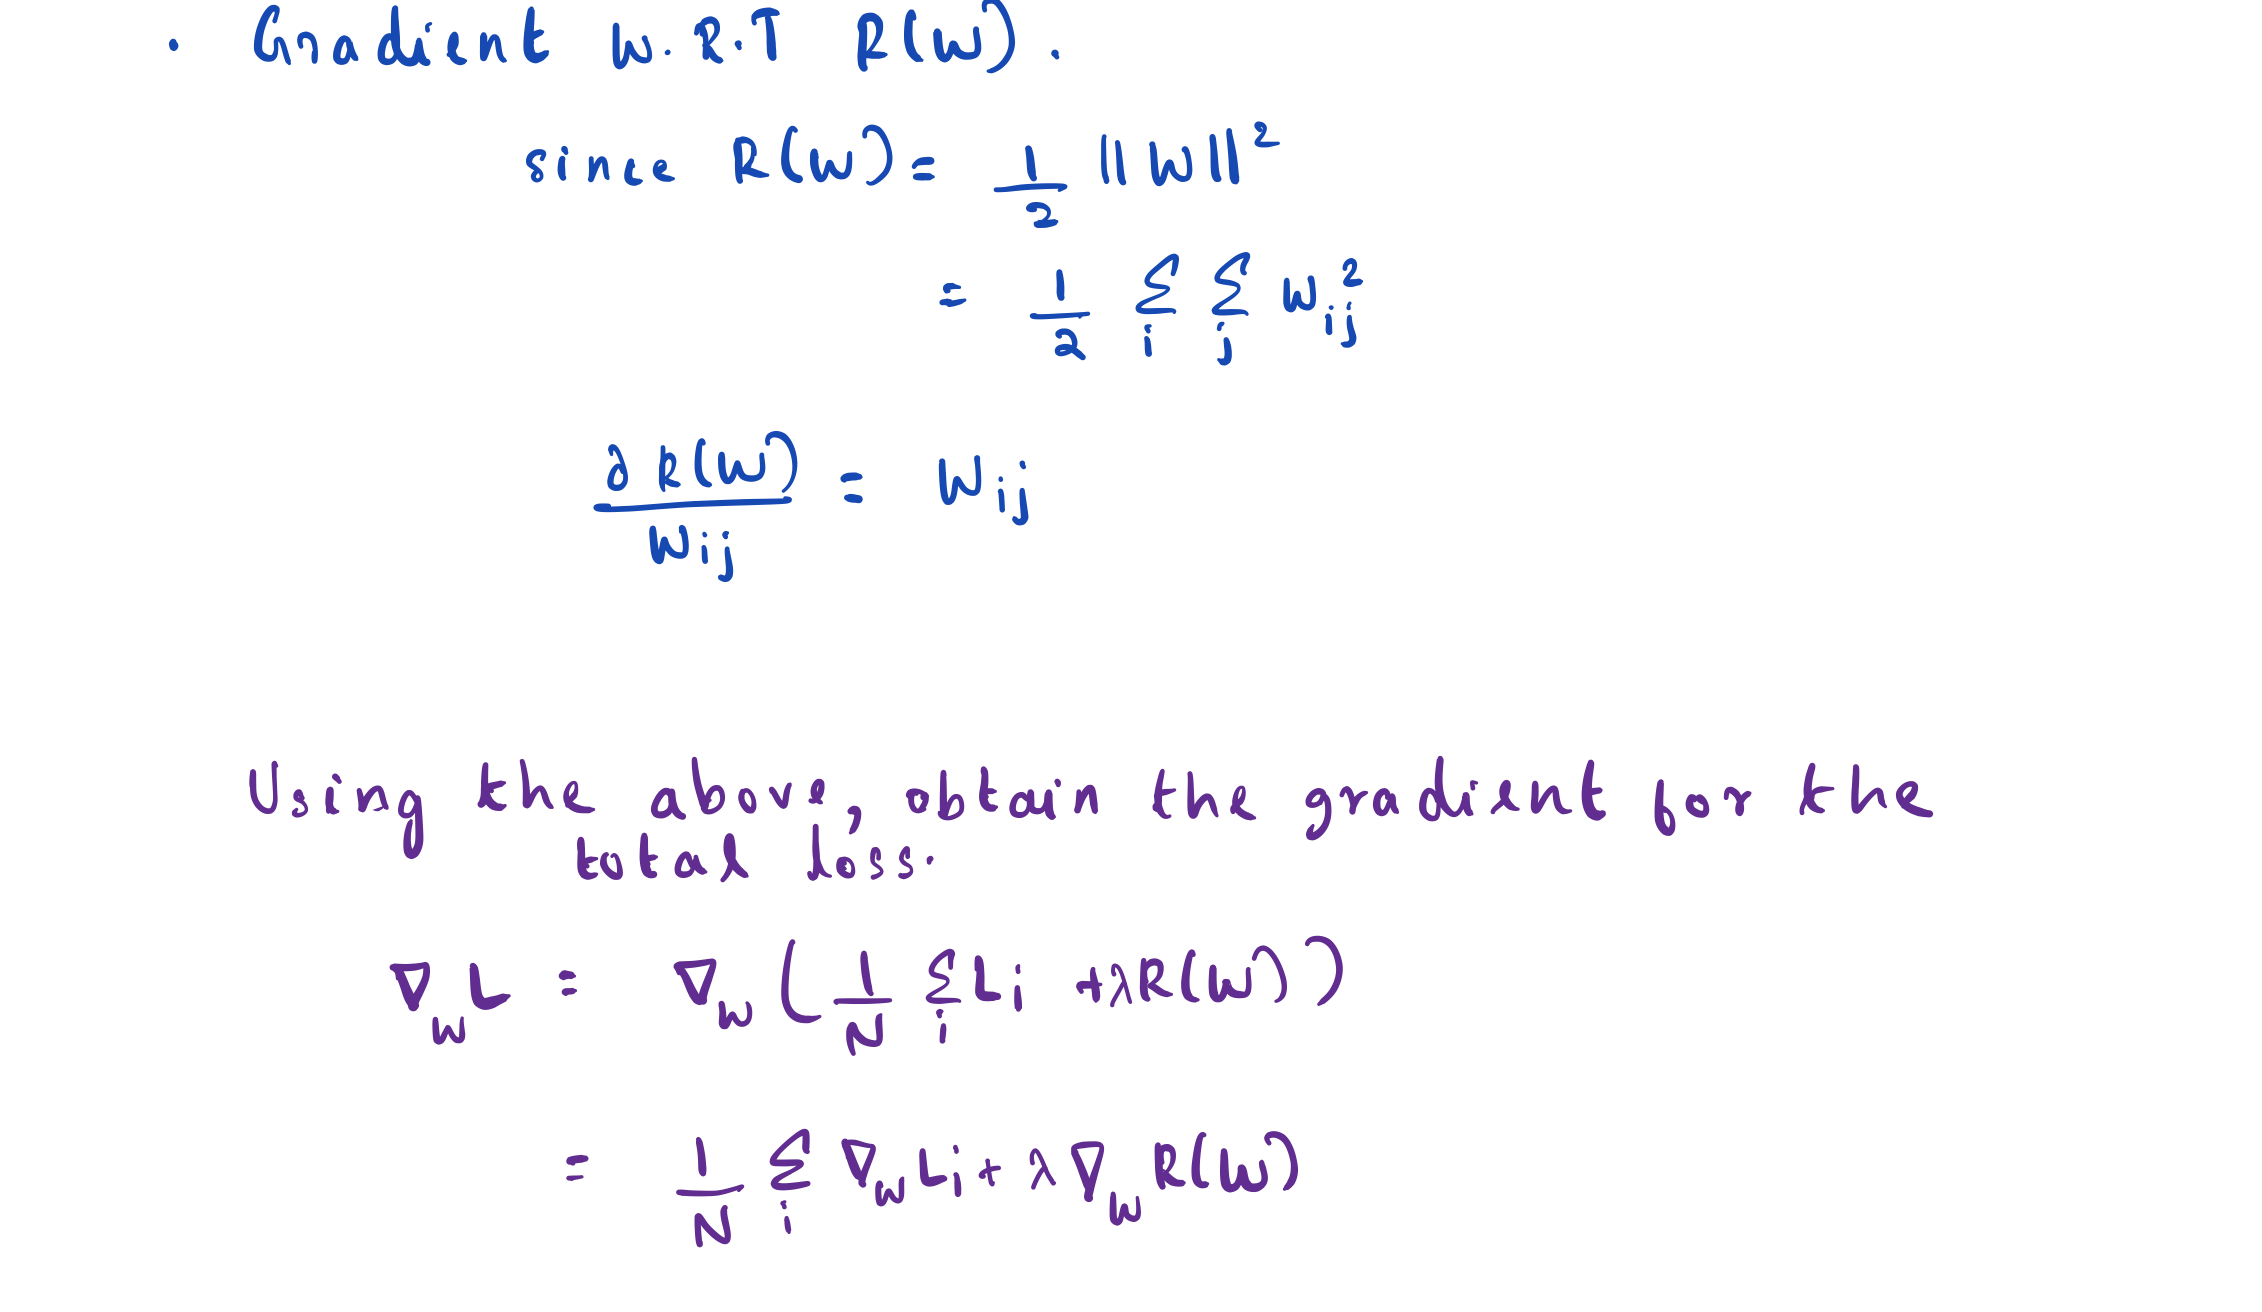

In [24]:
print("\n==>Linear SVM Gradient (2) \n")
Image("./files/notes/svm3.jpg")

In [25]:
pip install utils

In [26]:
import numpy as np
import os
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from utils import *
import tensorflow as tf
from sklearn.datasets import make_blobs,make_moons
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
import imageio
from IPython.display import Image
import sys

In [27]:
np.random.seed(0)
output_dir = "./output"
os.makedirs(output_dir,exist_ok=True)

**Code Organization**

Overall, we organize the code in the form of the following three classes:

* 1. LinearSVM:

A generic class that defines the overall structure for defining and training an SVM. You are not required to make any changes to this class. But go through the code carefully and understand the funtionality of each class variable and member function. It has unimplemented interfaces that has to be defined by the concrete classes that inherits LinearSVM.
         
* 2. ToyClassifier:
         
         
This class inherits the LinearSVM class and will be used for classification of a 2D toy dataset. This is the main class where you will have to put in your code to define the loss, gradient, etc as detailed in the respective areas.
         
* 3. ImageClassifier:
         
         
This class inherits the ToyClassifier class and hence its implemented gradients and losses. However this will be used for training on an Image dataset. You are required to fill in the code for initializing the model weights and visualizing the learned weights for each class. 
         
***You are requested to go through the code and understand the overall structure before filling in your snippets.*** 

* Make sure that the member variables of the class as defined in the __init__ function is utilized appropriately wherever necessary as per their functionality in your code snippets.

 

In [28]:
class LinearSVM():
    def __init__(self,x_dim=2,n_class=3,delta=1,lamda=0.1,lr=1e-3,batch_size=128,n_iter=2000,log_freq=10):
        self.x_dim      = x_dim          # Feature dimension
        self.n_class    = n_class        # No. of Classes
        self.delta      = delta          # Margin by which the scores of correct classes should be higher than incorrect ones
        self.lamda      = lamda          # The regularization hyperparameter
        self.lr         = lr             # The learning rate
        self.batch_size = batch_size     # Batch Size
        self.n_iter     = n_iter         # No. of training iterations
        self.log_freq   = log_freq       # Frequency of logging the progress
        self.history    = {
                        "loss":{"Training":[],"Validation":[],"Testing":[]},
                        "accuracy":{"Training":[],"Validation":[],"Testing":[]},
                        "weights":[],
                        "decision_surface":[]
                        }
        self.W          = self.initialize_weight()
        self.dataset    = self.load_dataset()
        self.train_dataset, self.validation_dataset, self.test_dataset = self.split_dataset(self.dataset)
        
        self.student_name = student_name
        self.student_id   = student_id
        self.student_email=student_email
        
    def split_dataset(self,dataset):
        X_train, X_test, y_train, y_test = train_test_split(dataset[0],dataset[1],test_size=0.33,random_state=23)
        X_test, X_val, y_test, y_val     = train_test_split(X_test,y_test, test_size=0.33,random_state=23)
        return (X_train,y_train),(X_val,y_val),(X_test,y_test)

    def train(self):
        X,Y = self.train_dataset
        n_data = X.shape[0]
        for iteration in range(1,self.n_iter+1):
            batch_idx = np.random.choice(range(0,n_data),self.batch_size)
            x_batch   = X[batch_idx]
            y_batch   = Y[batch_idx]
            loss      = self.loss(x_batch,y_batch)
            gradient  = self.gradient(x_batch,y_batch)
            y_pred    = self.predict(x_batch)
            accuracy  = self.accuracy(y_pred,y_batch)
            self.update_weight(gradient)
            
            if(iteration%self.log_freq==0):
                self.log("Training",iteration,loss,accuracy)
                validation_loss,validation_acc = self.validate()
                self.log("Validation",iteration,validation_loss,validation_acc)
                self.history["weights"].append(self.W)
                self.history["decision_surface"].append(self.visualize_weights())

        test_loss,test_acc = self.test()
        self.log("Testing",iteration,validation_loss,validation_acc)
        
    def validate(self):
        X,Y = self.validation_dataset
        n_data = X.shape[0]
        batch_idx = np.random.choice(range(0,n_data),self.batch_size)
        x_batch   = X[batch_idx]
        y_batch   = Y[batch_idx]
        loss      = self.loss(x_batch,y_batch)
        y_pred    = self.predict(x_batch)
        accuracy  = self.accuracy(y_pred,y_batch)
        return loss,accuracy

    def test(self):
        X,Y = self.test_dataset
        n_data = X.shape[0]
        accuracies = []
        losses     = []
        for iteration in range(0,n_data//self.batch_size):
            batch_idx = range(iteration*self.batch_size,(iteration+1)*self.batch_size)
            x_batch   = X[batch_idx]
            y_batch   = Y[batch_idx]
            loss      = self.loss(x_batch,y_batch)
            y_pred    = self.predict(x_batch)
            accuracy  = self.accuracy(y_pred,y_batch)
            accuracies.append(accuracy)
            losses.append(loss)
        return np.mean(losses), np.mean(accuracies)    
        
    def log(self,mode,iteration,loss,accuracy):
        print("--"*40)
        print("{:10s} | Iter : {:5f}| Loss : {:5f}| Accuracy: {:5f}".format(mode,iteration,loss,accuracy))
        self.history["loss"][mode].append(loss)
        self.history["accuracy"][mode].append(accuracy)
        a = 1


    def print_observations(self):
        self.collect_observations()
        print(self.observations)

    def check_gradients(self):
        x,y = self.train_dataset
        x = x[:128]
        y = y[:128]    
        curr_W = self.W
        def eval_grad_loss(W):
            self.W = W
            return self.loss(x,y)
        numeric_gradient  = eval_numerical_gradient(eval_grad_loss,self.initialize_weight())
        analytic_gradient = self.gradient(x,y)
        numeric_gradient  = numeric_gradient.reshape([-1,])
        analytic_gradient = analytic_gradient.reshape([-1,])
        relative_error = np.average(np.abs(numeric_gradient - analytic_gradient) / numeric_gradient, axis=0)
        print(" Numerical & Analytic Gradient Relative Error : ",relative_error)
        self.W = curr_W

    def print_observations(self):
        self.collect_observations()
        print(self.observations)

    def initialize_weight(self):
        raise NotImplementedError
        
    def predict(self,x,W=None):
        raise NotImplementedError
    
    def accuracy(self,Y_pred,Y_true):
        return accuracy_score(Y_pred,Y_true)
    
    def loss(self,X,Y):
        raise NotImplementedError
    
    def gradient(self,X,Y):
        raise NotImplementedError
    
    def update_weight(self,gradient):
        raise NotImplementedError
                
    def collect_observations(self):
        raise NotImplementedError

----
**1.1 Overview of Point Distribution For The Parts of ToyClassifier to be Completed**

----
    
    1. initialize_weight() : 5 Points
    2. loss()              : 10 Points
    3. gradient()          : 10 Points
    4. update_weight()     : 5 Points
    5. predict()           : 5 Points
    6. observations        : 5 Points
   
    7. Tuning hyperparameters to achieve good performance : 10 Points
    
    Total : 50 Points

In [29]:
print("\nSample Output\n")
with open('files/sample_output/svm_toy.gif','rb') as f:
    # display(Image(data=f.read(),format='gif'))
    display(Image(data=f.read()))

Output hidden; open in https://colab.research.google.com to view.

In [30]:

class ToyClassifier(LinearSVM):
    def __init__(self, **kwargs):
        super(ToyClassifier,self).__init__(**kwargs)
    
    def initialize_weight(self, distribution="normal"):
        """
        Function to initialize the parameters (W) of the model.
        Input   : None
        Returns : A numpy array of dimension equal to the weight dimension (feature_dim x #classes)
                  The values can be drawn from any distribution of your choice - normal distribution,
                  uniform distribution, etc. Try initialization using different distributions and pick the
                  best performing.
        
        (5 Points)
        """
        ### BEGIN - Enter your code below ###

        if distribution == "normal":
          W = np.random.normal(size=(self.x_dim, self.n_class))
        elif distribution == "uniform":
          W = np.random.uniform(size=(self.x_dim, self.n_class))
        return W
        
        ### END ###
    
    def load_dataset(self):
        """
        Function to load the dataset.
        Input   : None
        Returns : Data samples (X) and their corresponding labels (y) 
        """
        X,y =  make_blobs(100000,cluster_std=0.40,centers=[(-2,0),(2,0),(0,2),(0,-2)])
        return X,y 

    def visualize_weights(self):
        """
        Function to visualize the learned decision surface.
        Input   : None
        Returns : The plotted decision surface
        """
        X,y = self.train_dataset
        X = X[:5000]
        y = y[:5000]
        fig, ax = plt.subplots()
        title = ('Decision surface')
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)
        plot_contours(ax, self, xx, yy, cmap=plt.cm.Spectral, alpha=0.6)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.Spectral, s=30, edgecolors='k')
        ax.set_ylabel('Y Axis')
        ax.set_xlabel('X Axis')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return image_from_plot

    
    def loss(self,X,y):
        """
        Function to compute the loss. (Refer to the notes for loss definition)
        Input   : Batch of data samples (X) and its labels (y)
        Returns : The SVM loss on the inputed data batch. (scalar)
        
        (10 Points)
        """
        ### BEGIN - Enter your code below ###
        N = X.shape[0]
        loss = 0.0
        scores = np.dot(X, self.W)
        right_class_score = scores[np.arange(N), y]
        right_score = scores - right_class_score[:,np.newaxis]
        loss_i = np.maximum(0, right_score +self.delta)
        loss_i[np.arange(N), y] = 0
        loss = np.sum(loss_i)
        loss /= N
        loss += 0.5 * self.lamda * np.sum(W * W)

        return loss
        
        ### END ###
    
    def gradient(self,X,y):
        """
        Function to compute the gradient. (Refer to the notes for gradient computation help)
        Input   : Batch of data samples (X) and its labels (y)
        Returns : The gradient w.r.t the weights (W) for the loss on the inputed data batch. (dim = dim of W)
        
        (10 Points)
        """
        ### BEGIN - Enter your code below ###
        N = X.shape[0]
        scores = np.dot(X, self.W)

        right_class_score = scores[np.arange(N), y]
        right_score = scores - right_class_score[:,np.newaxis]
        loss_i = np.maximum(0, right_score +self.delta)
        loss_i[np.arange(N), y] = 0

        dW = self.W
        X_mask = np.zeros(loss_i.shape)
        X_mask[loss_i > 0] = 1
        count = np.sum(X_mask,axis=1)
        X_mask[np.arange(N),y] = -count

        dW = np.dot(X.T, X_mask)
        dW /= N
        dW += self.lamda*W
        return dW        
        ### END ###
    

    def update_weight(self,gradient):
        """
        Function to update the weights using the gradient update rule : W = W - learning_rate x gradients.
        Input   : Gradients
        Returns : Nothing.
                  Use the gradient inputed to update the weight matrix (The weight matrix and learning rate are a member variable of the class. See __init__ of LinearSVM for all member variables)
        
        (5 Points)
        """
        ### BEGIN - Enter your code below ###
        
        self.W = self.W - (self.lr*gradient)
        ### END ###
    

    def predict(self,X):
        """
        Function to predict the target class for the inputed batch of samples the gradient( hint: class having highest score as assigned by the SVM)
        Input   : Batch of data samples (X) (- dim: batch_size x feature_dim)
        Returns : The predicted labels      (- dim: batch_size)
        
        (5 Points)
        """
        ### BEGIN - Enter your code below ##*
        dec = np.dot(X, self.W) + self.delta
        y_pred = dec.argmax(axis=1)
        # print(y_pred)
        return np.array(y_pred)
        ### END ###
    

    def collect_observations(self):
        self.observations = """
        ===============================================================
        <ID> 1.1 2D TOY CLASSIFICATION-GRADIENT BASED LINEAR SVM </ID> 
        ---------------------------------------------------------------
        Write Your Observations and Takeaways In the Space Below.
        (Note: Do not remove the existing content)
        ---------------------------------------------------------------
        <BEGIN>
        1. Here we have implemented SVM Multiclass Linear Classifier from Scratch.
        2. Appropriate Delta of the given dataset is best observed is in between 5 and 10.
        3. Lambda or Regularisation Hyperparameter best observed is aroud 1e-3.
        4. Learning Rate best observed is 1000.
          * Increasing or decreasing Learning Rate from here increase our Relative Error
        5. N-Iter best observerd is 10,000 or more.
          * More the Iteration more the better or Model becomes.
        6. Batch Size best observed is 
        7. log_freq - Frequency of Logging Pr is best at 10



        <END>
        ---------------------------------------------------------------   
        
        (5 Points)
                            """



**CODE BLOCKS TO CHECK THE WORKING OF THE IMPLEMENTED FUNCTIONS**

In [46]:
toy_classifier = ToyClassifier(n_class=4,n_iter=50,log_freq=50,delta=10)
X,Y       = toy_classifier.train_dataset
x_batch   = X[:5]
y_batch   = Y[:5]

print("\n==>Checking Working of Initialize Weight Function")
W      = toy_classifier.initialize_weight()
print("----- Running Successfull: Weight Dimensionn : ",W.shape) 

print("\n==>Checking Working of Loss Function")
loss      = toy_classifier.loss(x_batch,y_batch)
print("----- Running Successfull: Loss Value : ",loss)


print("\n==>Checking Working of Gradient Function")
gradient      = toy_classifier.gradient(x_batch,y_batch)
if(gradient.shape == toy_classifier.W.shape):
    print("----- Running Successfull: Gradient Dim : ",gradient.shape)
else:
    print("----- Error : Gradient Dim Mismatch. Dim of Gradient Provided :  ",gradient.shape," Weight Dim : ",toy_classifier.W.shape)
toy_classifier.check_gradients()

print("\n==>Checking Working of Predict Function")
y_pred    = toy_classifier.predict(x_batch)
if(y_pred.shape == y_batch.shape):
    print("----- Running Successfull: y_pred : ",y_pred, "y_true : ",y_batch)
else:
    print("----- Error: Shape Mismatch - y_pred : ",y_pred, "y_true : ",y_batch)


==>Checking Working of Initialize Weight Function
----- Running Successfull: Weight Dimensionn :  (2, 4)

==>Checking Working of Loss Function
----- Running Successfull: Loss Value :  26.847525646670537

==>Checking Working of Gradient Function
----- Running Successfull: Gradient Dim :  (2, 4)
 Numerical & Analytic Gradient Relative Error :  0.9944521483685562

==>Checking Working of Predict Function
----- Running Successfull: y_pred :  [1 2 1 1 2] y_true :  [2 2 2 0 2]


----
**Training And Tuning**

----
Change and Tune the hyperparameter values below till you achieve a very high validation accuracy ~ 99%.
Note that the n_class and x_dim should be 4 and 2 respectively as we have 2D toy data consisting of 4 classes 

(10 Points)

In [47]:
### BEGIN - CHANGE/TUNE THE FOLLOWING HYPERPARAMETER VALUES###

delta     = 7
lamda     = 0.0001
lr        = 1e3
batch_size= 2
n_iter    = 5000
log_freq  = 100

### END ###

toy_classifier = ToyClassifier(x_dim=2,n_class=4,delta=delta,lamda=lamda,lr=lr,batch_size=batch_size,n_iter=n_iter,log_freq=log_freq)
toy_classifier.train()
# print("as")
imageio.mimsave('{}/svm_toy.gif'.format(output_dir), toy_classifier.history["decision_surface"])
save(toy_classifier,directory=output_dir)

print("==>Gradient Check:\n")
toy_classifier.check_gradients()

print("\n==>Visualization of Decision Surface Over Training Iterations\n")
with open('{}/svm_toy.gif'.format(output_dir),'rb') as f:
    display(Image(data=f.read()))
    
print("==>Observations:\n")
toy_classifier.print_observations()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# dlt = [1, 5, 10, 50, 100]
# lda = [1e-3, 1e-2, 1e-1, 1e0]
# ler = [1, 1e2, 1e3, 1e4]
# batchsz = [1, 2, 3, 4, 5]
# ntr = [1000, 3000, 5000, 10000]
# lg = [1, 10, 50, 100]

# for k in batchsz:
#   toy_classifier = ToyClassifier(x_dim=2,n_class=4,batch_size=k)
#   toy_classifier.train()
#   print(k)
#   toy_classifier.check_gradients()

# for k in dlt:
#   toy_classifier = ToyClassifier(x_dim=2,n_class=4,delta=k)
#   toy_classifier.train()
#   print(k)
#   toy_classifier.check_gradients()

# for k in lda:
#   toy_classifier = ToyClassifier(x_dim=2,n_class=4,lamda=k)
#   toy_classifier.train()
#   print(k)
#   toy_classifier.check_gradients()

# for k in ler:
#   toy_classifier = ToyClassifier(x_dim=2,n_class=4,lr=k)
#   toy_classifier.train()
#   print(k)
#   toy_classifier.check_gradients()

# for k in ntr:
#   toy_classifier = ToyClassifier(x_dim=2,n_class=4,n_iter=k)
#   toy_classifier.train()
#   print(k)
#   toy_classifier.check_gradients()

# for k in lg:
#   toy_classifier = ToyClassifier(x_dim=2,n_class=4,log_freq=k)
#   toy_classifier.train()
#   print(k)
#   toy_classifier.check_gradients()


----
**1.2 Overview of Point Distribution For The Parts of ImageClassifier to be Completed**

----
    
    1. initialize_weight() : 2.5 Points
    2. visualize_weights() : 5 Points
    3. observations        : 2.5 Points
   
    4. Tuning hyperparameters to achieve good performance : 10 Points
    
    Total : 20 Points

In [ ]:
print("\nSample Output\n")
with open('files/sample_output/svm_image.gif','rb') as f:
    display(Image(data=f.read()))

In [ ]:

class ImageClassifier(ToyClassifier):
    def __init__(self, **kwargs):
        super(ImageClassifier,self).__init__(**kwargs)

    def initialize_weight(self, distribution="normal"):
        """
        Function to initialize the parameters (W) of the model.
        Input   : None
        Returns : A numpy array of dimension equal to the weight dimension (feature_dim x #classes)
                  The values can be drawn from any distribution of your choice - normal distribution,
                  uniform distribution, etc. Try initialization using different distributions and pick the
                  best performing.
        
        (2.5 Points)
        """
        ### BEGIN - Enter your code below ###
        if distribution == "normal":
          W = np.random.normal(size=(self.x_dim, self.n_class))
        elif distribution == "uniform":
          W = np.random.uniform(size=(self.x_dim, self.n_class))
        return W

        ### END ###
    
    def visualize_weights(self):
        """
        Function to visualize the learned parameters (W) of the model.
        Input   : None
        Returns : An image frame for the plotted weights
        
        The cifar10 images are of size 32x32x3 (=3072 pixels) and there are 10 classes. 
        Thus, The weights of the SVM would be of size 3072x10. Thus, for each of the 10 classes we
        have a weight of dimension 3072 (=32x32x3). Since we have a linear SVM, the i-th 32x32x3 weight vector
        can be interpreted as the features that the SVM is learning inorder to distinguish class i from other
        classes. The objective of this function is to visualize each of those weight matrices. You are required 
        to extract the weight vector for each of the class, reshape it to 32x32x3 and plot it as an image along 
        with its class title.  
        
        The list of classes ordered as per their labels is given in the function for your convenience.
        The figure has also been defined as having 10 subplots for each of the classes. You have to plot the weight 
        for the i-th class on the i-th axis (i.e. ax[i] ).
        
        PS: Do not call plt.show(). Code for checking the output is given in the following cell.
        
        (5 Points)
        """
        
        classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
        fig, ax = plt.subplots(1,10,figsize=(20,5))
        
        ### BEGIN - Enter your code below ###
        # w = self.W[:-1,:] 
        # w = w.reshape(32, 32, 3)
        # w_min, w_max = np.min(w), np.max(w)
        # for i in range(10):
        #   plt.subplot(2, 5, i + 1)
        #   wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)        
        ### END ###
    
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return image_from_plot
    
    def load_dataset(self):
        (x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
        mean_image = np.mean(x_train, axis=0)
        x_train = x_train - mean_image
        x_train = x_train.reshape([x_train.shape[0],-1])
        y_train = y_train.reshape([y_train.shape[0]])
        return (x_train, y_train)

    def clear_dataset(self):
        self.dataset,self.train_dataset, self.validation_dataset, self.test_dataset = None, None, None, None
    
    def collect_observations(self):
        self.observations = """
        ===============================================================
        <ID> 1.2 IMAGE CLASSIFICATION - GRADIENT BASED LINEAR SVM </ID> 
        ---------------------------------------------------------------
        Write Your Observations and Takeaways In the Space Below.
        (Note: Do not remove the existing content & dashed lines)
        ---------------------------------------------------------------
        <BEGIN>
        My Observation
        1. Here SVM is used for image classification.
        2. Best Batchsize for the dataset is observed to be 200
        3. Best lambda observed to be 1e-5
        4. Best Learning Rate is observed to be 1e-3


        <END>
        --------------------------------------------------------------- 
        
        (2.5 Points)
                            """


**CODE BLOCKS TO CHECK THE WORKING OF THE IMPLEMENTED FUNCTIONS**


==>Checking Working of Initialize Weight Function
----- Running Successfull: Weight Dimensionn :  (3072, 10)

==>Checking Working of Visualize Weight Function


IndexError: ignored

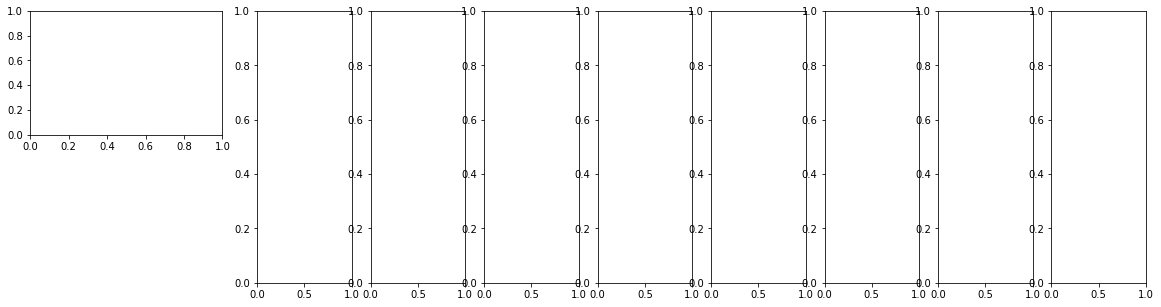

In [44]:
image_classifier = ImageClassifier(n_class=10,x_dim=3072,n_iter=50,log_freq=50,delta=10)
X,Y       = image_classifier.train_dataset
x_batch   = X[:5]
y_batch   = Y[:5]

print("\n==>Checking Working of Initialize Weight Function")
W      = image_classifier.initialize_weight()
print("----- Running Successfull: Weight Dimensionn : ",W.shape) 

print("\n==>Checking Working of Visualize Weight Function")
image_frame = image_classifier.visualize_weights()
fig,ax = plt.subplots(1,1,figsize=(20,5))
plt.imshow(image_frame)

----
**Training And Tuning**

----

Change and Tune the hyperparameter values below till you achieve a reasonable validation accuracy. Note that 
since there are 10 classes, chance would be at 10% accurate. Since we are using linear SVM to classify images, it is not expected that we get very high accuracy. A validation accuracy close to 40% can be considered good enough.

Note that the n_class and x_dim should be 10 and 3072 (=32x32x3) respectively.

(10 Points)

In [ ]:
### BEGIN - CHANGE/TUNE THE FOLLOWING HYPERPARAMETER VALUES###

delta     = 5
lamda     = 1e-4
lr        = 1e0
batch_size= 32
n_iter    = 5000
log_freq  = 500

### END ###

image_classifier = ImageClassifier(x_dim=3072, n_class=10,delta=delta,lamda=lamda,lr=lr,batch_size=batch_size,n_iter=n_iter,log_freq=log_freq)
image_classifier.train()
image_classifier.clear_dataset()
imageio.mimsave('{}/svm_image.gif'.format(output_dir), image_classifier.history["decision_surface"])
save(image_classifier,directory=output_dir)
                                
print("\n==>Weight Visualization\n")
with open('{}/svm_image.gif'.format(output_dir),'rb') as f:
    display(Image(data=f.read(),format='gif'))

print("==>Observations:\n")
image_classifier.print_observations()

---
**Part-2: Nonlinear SVM Using the Sklearn Package** (30 Points)
---

 * In the first part we implemented a Linear SVM using gradient descent. However, not all datasets are linearly separable. The wide popularity of SVM is due its ability learn complex non linear decision boundaries using kernels. However, gradient computation becomes hard while using kernels. Hence we will use the predefined SVM Classifier from the sklearn package (SVC) which uses the constrained quadratic optimization method (using lagrangian multipliers).

 * We will work with a non-linearly separable 2D toy dataset consisting of 2 Classes.
 

----
 **2.1 Overview of Point Distribution For The Parts of NonLinearSVM to be Completed**
 
 ----
    
    1. build_model()       : 2.5 Points
    2. visualize()         : 12.5 Points
    3. observations        : 5 Points
   
    4. Tuning hyperparameters to achieve good performance : 10 Points
    
    Total : 30 Points


Sample Output



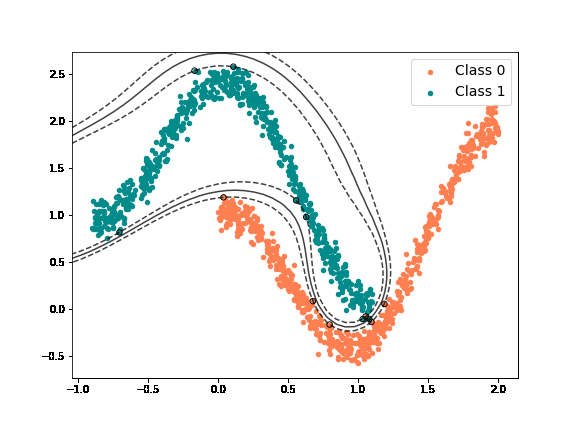

In [61]:
print("\nSample Output\n")
Image('files/sample_output/svm_nonlinear.png')

In [48]:
import numpy as np
import os
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.datasets import make_moons,make_circles
from utils import *
import matplotlib.pyplot as plt

In [68]:
class NonLinearSVM():
    def __init__(self,C=1e-4,kernel="linear",degree=1):
        self.model      = self.build_model(C=C,kernel=kernel,degree=degree)
        self.dataset    = self.load_dataset()
        self.train_dataset, self.validation_dataset, self.test_dataset = self.split_dataset(self.dataset)
        
        self.student_name = student_name
        self.student_id   = student_id
        self.student_email=student_email
        
    def split_dataset(self,dataset):
        X_train, X_test, y_train, y_test = train_test_split(dataset[0],dataset[1],test_size=0.33,random_state=23)
        X_test, X_val, y_test, y_val     = train_test_split(X_test,y_test, test_size=0.33,random_state=23)
        return (X_train,y_train),(X_val,y_val),(X_test,y_test)

    def train(self):
        X,Y    = self.train_dataset
        self.model.fit(X,Y)
        train_accuracy = self.model.score(X,Y)
        val_accuracy   = self.validate()
        print("Training Accuracy : {} | Validation Accuracy : {} \n".format(train_accuracy,val_accuracy))
        
        print("\n==>Decision Surface Visualization\n")
        self.decision_surface = self.visualize()

    def validate(self):
        X,Y = self.validation_dataset
        return self.model.score(X,Y)

    def test(self):
        X,Y = self.test_dataset
        return self.model.score(X,Y)

    def build_model(self,C=1e-4,kernel="linear",degree=1):
        """
        Function to build the sklearn SVM model using the given hyperparameters 
        
        Input   : Hyperparameters C, kernel and degree
                    Refer to the SVC class documentation from sklearn to identify the utility and range of 
                    values for these hyperparameters
                    
        Returns : An Instance of the SVM Classifier from sklearn instantiated with the given hyperparameters
        
        (2.5 Points)
        """
        ### BEGIN - Enter your code below ###
        self.model =  SVC(kernel=kernel, C=C, degree=degree)
        return self.model
        
        ### END ###
    
    def print_observations(self):
        self.collect_observations()
        print(self.observations)

    def load_dataset(self):
        n_samples = 1000
        de_linearize = lambda X: np.cos( np.pi*X) + np.sin(  0.2*np.pi * X )
        x1 = np.sort(np.random.rand(n_samples)) * 2
        x2 = de_linearize(x1) + np.random.randn(n_samples) * 0.1
        X1 = np.vstack([x1,x2]).T
        Y1 = np.zeros((n_samples)) 
        x2 = -1*(de_linearize(x1) + np.random.randn(n_samples) * 0.1)
        X2 = np.vstack([x1-0.9*np.ones_like(x1),x2+2*np.ones_like(x2)]).T
        Y2 = np.ones((n_samples)) 
        X  = np.append(X1,X2,axis=0)
        Y  = np.append(Y1,Y2,axis=0)
        return X,Y
    
    def predict(self,x):
        return self.model.predict(x)

    def visualize(self):
        """
        Function to visualize the SVM decision boundary 
        
        Input   : None  
        Returns : An image frame for the generated plot
        
        The datapoints and their labels are given below as X and y. You are required to scatter plot
        the data points colored differently according to their classes. Also plot the contour for the 
        SVM decision boundary, including the margins. Encircle the support vectors. ( View sample output
        provided earlier)
        
        You will have to refer to the SVC documentation from sklearn for obtaining the decision surface 
        for the given data points. ( Note that the SVM model is present in self.model )
        (12.5 Points)
        
        PS: Only fill in the space provided. Do not change the other code. plt.show() is already called later,
        so avoid using it in your snippet.
        
        """
        
        X,y = self.train_dataset
        X = X[:5000]
        y = y[:5000]
        fig, ax = plt.subplots(figsize=(8,6))

        ### BEGIN - Enter your code below ###
        support_vectors = self.model.support_vectors_
        # support_vector_indices = model.support_
        # support_vectors_per_class = model.n_support_
        # print("Hello")
        # print(X.shape, y.shape)
        h = .02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

        plt.scatter(support_vectors[:,0], support_vectors[:,1], edgecolors="yellow", linewidths=2)

        Z = self.model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.imshow(Z, interpolation='nearest',
                  extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
                  origin='lower', cmap=plt.cm.PuOr_r)
        contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                              linestyles='dashed')
        plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired,
                    edgecolors='k', label=f"Class {Y}")

        plt.title('Linearly separable data with support vectors')
        plt.xlabel('X1')
        plt.ylabel('X2')
        # plt.xticks(())
        # plt.yticks(())
        
        ### END ###
    
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.show()
        plt.close()
        return image_from_plot
    
    def collect_observations(self):
        self.observations = """
        ===============================================================
        <ID> 2.1 2D TOY CLASSIFICATION - NonLinear SVM </ID> 
        ---------------------------------------------------------------
        Write Your Observations and Takeaways In the Space Below.
        (Note: Do not remove the existing content & dashed lines)
        ---------------------------------------------------------------
        <BEGIN>
        1. Here we have implemented NonLinear SVM for classification using Sklearn Library
        2. Best Kernel observed is RBF.
          * RBF gives the best result and is prefered kernel her for classification
        3. Best value of C observed is 100
          * Bigger the C, more better fitting will be observed till it reaches condition of overfitting
          * Lower the C is Worse the fitting goes till it becomes underfitting
        4. Model has High Accuray with more than 90%


        <END>
        ---------------------------------------------------------------   
        
        (5 Points)
                            """

    

**CODE BLOCKS TO CHECK THE WORKING OF THE IMPLEMENTED FUNCTIONS**

---------
[[-0.50582584  1.53472602]
 [ 0.66188396 -0.16699161]
 [ 0.85166421 -0.37675533]
 [ 1.40700853  0.54146453]
 [-0.05800119  2.29992708]]
[1. 0. 0. 0. 1.]

==>Checking Working of Build Model Function
----- Running Successfull

==>Checking Working of Visualize Weight Function


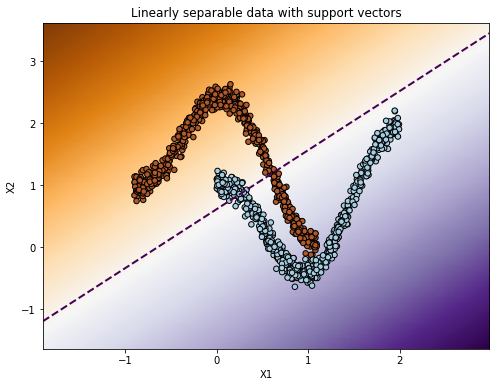

In [69]:
nonlinear_classifier = NonLinearSVM()
X,Y       = nonlinear_classifier.train_dataset
x_batch   = X[:5]
y_batch   = Y[:5]
print("---------")
print(x_batch)
print(y_batch)


print("\n==>Checking Working of Build Model Function")
nonlinear_classifier.model = nonlinear_classifier.build_model(C=1,kernel="linear",degree=1)
nonlinear_classifier.model.fit(x_batch,y_batch)
print("----- Running Successfull") 

print("\n==>Checking Working of Visualize Weight Function")
image_frame = nonlinear_classifier.visualize()

----
**Training And Tuning**

----
Change and Tune the provided hyperparameter values below till you achieve a very high validation accuracy ~ 99%. Refer to the __Sklearn SVC Documentation__ for details on the function and range of values for the hyperparameters given below.

(10 Points)

Training Accuracy : 0.8059701492537313 | Validation Accuracy : 0.8073394495412844 


==>Decision Surface Visualization



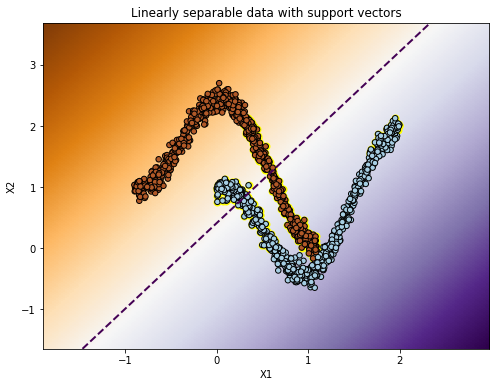

 C used  100
0.8122171945701357
Training Accuracy : 0.7843283582089552 | Validation Accuracy : 0.7981651376146789 


==>Decision Surface Visualization



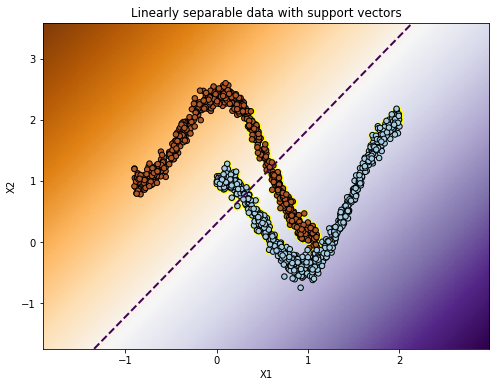

 C used  10
0.7941176470588235
Training Accuracy : 0.8074626865671641 | Validation Accuracy : 0.8302752293577982 


==>Decision Surface Visualization



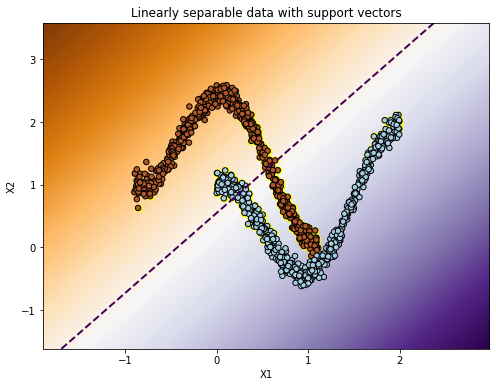

 C used  1
0.830316742081448
Training Accuracy : 0.7932835820895522 | Validation Accuracy : 0.8119266055045872 


==>Decision Surface Visualization



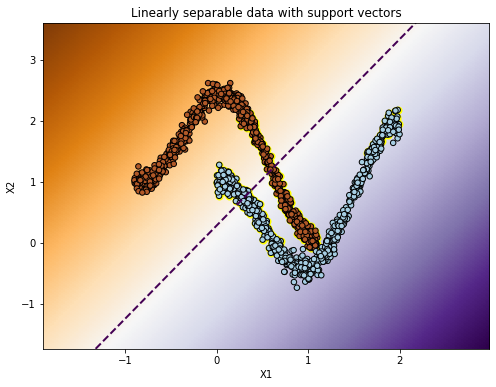

 C used  0.1
0.7918552036199095
Training Accuracy : 0.8067164179104478 | Validation Accuracy : 0.8165137614678899 


==>Decision Surface Visualization



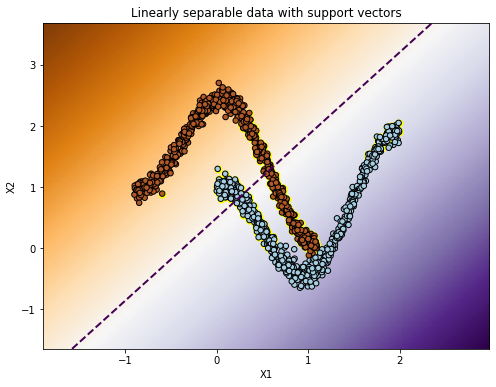

 C used  0.2
0.8167420814479638
Training Accuracy : 0.8007462686567164 | Validation Accuracy : 0.8027522935779816 


==>Decision Surface Visualization



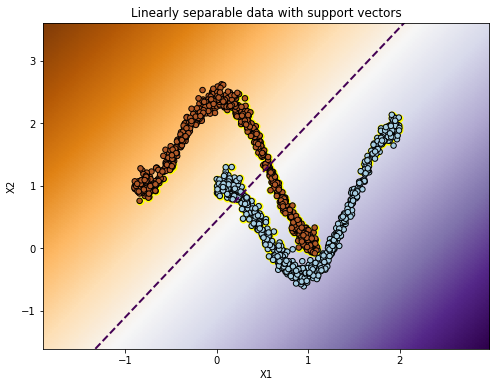

 C used  0.01
0.8099547511312217
Training Accuracy : 0.7977611940298508 | Validation Accuracy : 0.8165137614678899 


==>Decision Surface Visualization



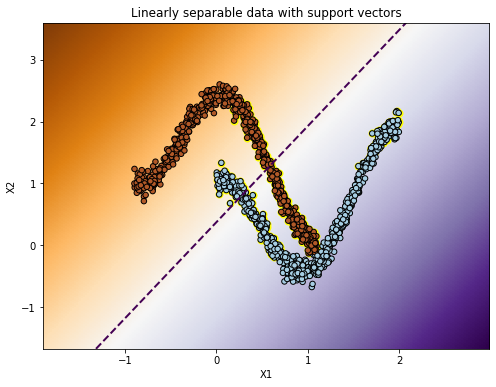

 C used  0.02
0.8054298642533937
Training Accuracy : 0.8104477611940298 | Validation Accuracy : 0.8211009174311926 


==>Decision Surface Visualization



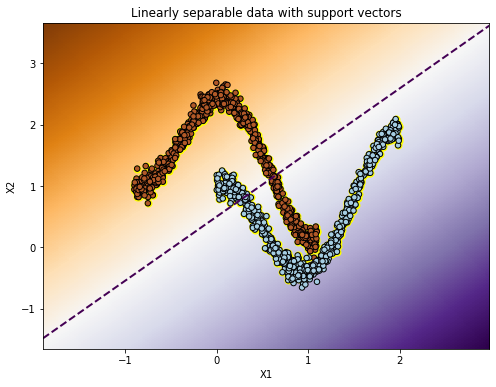

 C used  0.001
0.8190045248868778
Training Accuracy : 0.5007462686567165 | Validation Accuracy : 0.4724770642201835 


==>Decision Surface Visualization



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: UserWarning: No contour levels were found within the data range.


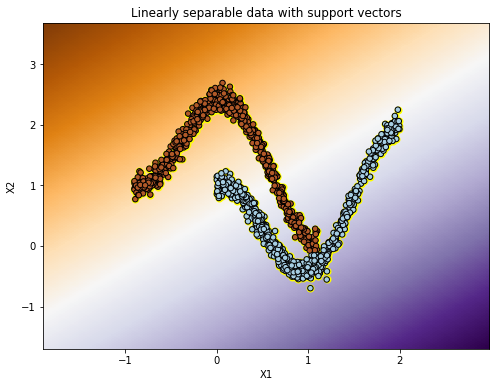

Kernel used here is  linear
0.5113122171945701
Training Accuracy : 0.5007462686567165 | Validation Accuracy : 0.4724770642201835 


==>Decision Surface Visualization



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: UserWarning: No contour levels were found within the data range.


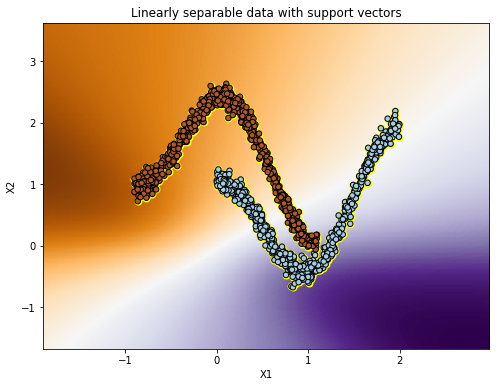

Kernel used here is  sigmoid
0.5113122171945701
Training Accuracy : 0.5007462686567165 | Validation Accuracy : 0.4724770642201835 


==>Decision Surface Visualization



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: UserWarning: No contour levels were found within the data range.


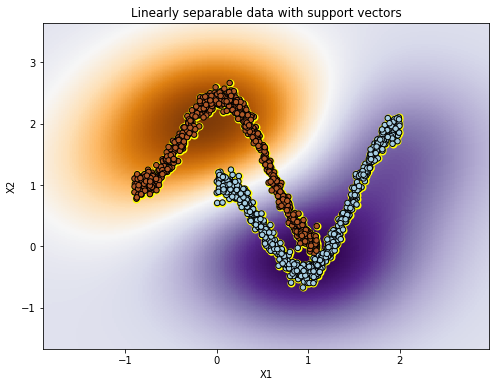

Kernel used here is  rbf
0.5113122171945701
Training Accuracy : 0.5007462686567165 | Validation Accuracy : 0.4724770642201835 


==>Decision Surface Visualization



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: UserWarning: No contour levels were found within the data range.


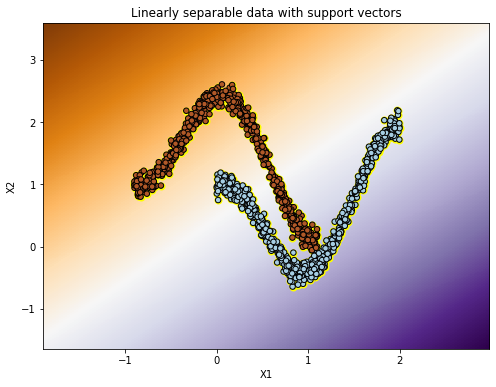

Kernel used here is  poly
0.5113122171945701


In [70]:
# kern = ["linear", "sigmoid", "rbf", "poly"]
# c = [100, 10, 1, 1e-1, 2*1e-1, 1e-2, 2*1e-2, 1e-3]
# degree = []
# for C in c:
#   nonlinear_classifier = NonLinearSVM(C=C)
#   nonlinear_classifier.train()
#   print(" C used ",C)
#   print(nonlinear_classifier.test())

# for kernel in kern:
#   nonlinear_classifier = NonLinearSVM(kernel=kernel)
#   nonlinear_classifier.train()
#   print("Kernel used here is ",kernel)
#   print(nonlinear_classifier.test())

# for d in degree:
#   nonlinear_classifier = NonLinearSVM(degree=degree)
#   nonlinear_classifier.train()
#   print("Kernel used here is ",kernel)
#   print(nonlinear_classifier.test())

Training Accuracy : 0.9985074626865672 | Validation Accuracy : 1.0 


==>Decision Surface Visualization



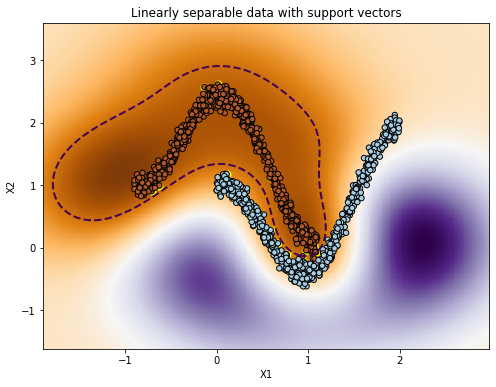

==>Observations:


        <ID> 2.1 2D TOY CLASSIFICATION - NonLinear SVM </ID> 
        ---------------------------------------------------------------
        Write Your Observations and Takeaways In the Space Below.
        (Note: Do not remove the existing content & dashed lines)
        ---------------------------------------------------------------
        <BEGIN>
        1. Here we have implemented NonLinear SVM for classification using Sklearn Library
        2. Best Kernel observed is RBF.
          * RBF gives the best result and is prefered kernel her for classification
        3. Best value of C observed is 100
          * Bigger the C, more better fitting will be observed till it reaches condition of overfitting
          * Lower the C is Worse the fitting goes till it becomes underfitting
        4. Best Degree observed is 


        <END>
        ---------------------------------------------------------------   
        
        (5 Points)
                            


In [71]:

### BEGIN - CHANGE/TUNE THE FOLLOWING HYPERPARAMETER VALUES###

C      = 100
kernel = "rbf"
degree = 2


### END ###

nonlinear_classifier = NonLinearSVM(C=C,kernel=kernel,degree=degree)
nonlinear_classifier.train()
imageio.imwrite('{}/svm_nonlinear.png'.format(output_dir), nonlinear_classifier.decision_surface)
save(nonlinear_classifier,directory=output_dir)
print("==>Observations:\n")
nonlinear_classifier.print_observations()


----
**Submision Check**
---

Use the following code blocks to see if your models have been saved properly. Verify that the visualizations generated from the loaded correspond to your latest obtained outputs.

==>Loading ToyClassifier


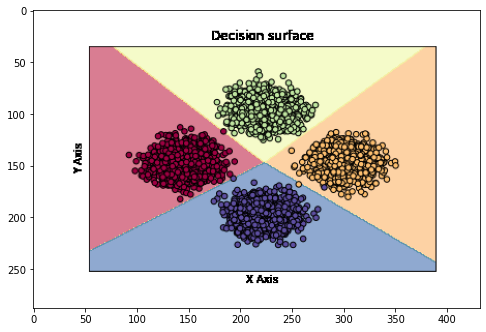

In [72]:
print("==>Loading ToyClassifier")
with open("{}/ToyClassifier".format(output_dir),"rb") as f:
    classifier = pickle.load(f)
plt.figure(figsize=(8,6))
plt.imshow(classifier.visualize_weights())

In [74]:
print("==>Loading ImageClassifier")
with open("{}/ImageClassifier".format(output_dir),"rb") as f:
    classifier = pickle.load(f)
    classifier.dataset    = classifier.load_dataset()
    classifier.train_dataset, classifier.validation_dataset, classifier.test_dataset = classifier.split_dataset(classifier.dataset)
    plt.figure(figsize=(20,5))
    plt.imshow(classifier.visualize_weights())

==>Loading ImageClassifier


FileNotFoundError: ignored

==>Loading Non Linear SVM Classifier


<Figure size 576x360 with 0 Axes>

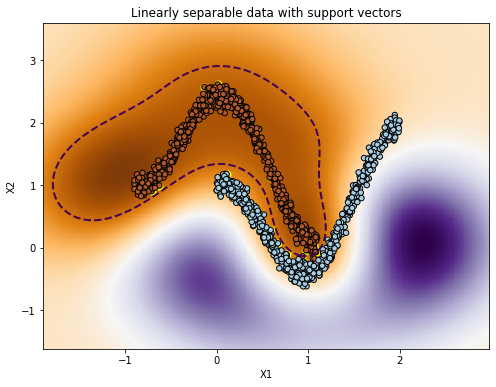

In [73]:
print("==>Loading Non Linear SVM Classifier")
with open("{}/NonLinearSVM".format(output_dir),"rb") as f:
    classifier = pickle.load(f)
    plt.figure(figsize=(8,5))
    classifier.visualize()